<a href="https://colab.research.google.com/github/Viktoriia-kama/ML_hw4-hw16/blob/main/HW11.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Створення нейронної мережі

У цьому завданні ми створимо повнозв'язну нейронну мережу, використовуючи при цьому низькорівневі механізми tensorflow.

Архітектура нейромережі представлена на наступному малюнку. Як бачиш, у ній є один вхідний шар, два приховані, а також вихідний шар. В якості активаційної функції у прихованих шарах буде використовуватись сигмоїда. На вихідному шарі ми використовуємо softmax.

Частина коду зі створення мережі вже написана, тобі потрібно заповнити пропуски у вказаних місцях.

## Архітектура нейронної мережі

<img src="http://cs231n.github.io/assets/nn1/neural_net2.jpeg" alt="nn" style="width: 400px;"/>


## Про датасет MNIST

Дану нейромережу ми будемо вивчати на датасеті MNIST. Цей датасет являє собою велику кількість зображень рукописних цифр розміром $28 \times 28$ пікселів. Кожен піксель приймає значення від 0 до 255.

Як і раніше, датасет буде розділений на навчальну та тестову вибірки. При цьому ми виконаємо нормалізацію всіх зображень, щоб значення пікселів знаходилось у проміжку від 0 до 1, розділивши яскравість кожного пікселя на 255.

Окрім того, архітектура нейронної мережі очікує на вхід вектор. У нашому ж випадку кожен об'єкт вибірки являє собою матрицю. Що ж робити? У цьому завданні ми "розтягнемо" матрицю $28 \times 28$, отримавши при цьому вектор, що складається з 784 елементів.

![MNIST Dataset](https://www.researchgate.net/profile/Steven-Young-5/publication/306056875/figure/fig1/AS:393921575309346@1470929630835/Example-images-from-the-MNIST-dataset.png)

Більше інформації про датасет можна знайти [тут](http://yann.lecun.com/exdb/mnist/).

In [58]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import keras as K
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, classification_report


In [49]:
num_classes = 10 # загальна кількість класів, у нашому випадку це цифри від 0 до 9
num_features = 784 # кількість атрибутів вхідного вектора 28 * 28 = 784

learning_rate = 0.001 # швидкість навчання нейронної мережі
training_steps = 3000 # максимальне число епох
batch_size = 256 # перераховувати ваги мережі ми будемо не на всій вибірці, а на її випадковій підмножині з batch_size елементів
display_step = 100 # кожні 100 ітерацій ми будемо показувати поточне значення функції втрат і точності

n_hidden_1 = 128 # кількість нейронів 1-го шару
n_hidden_2 = 256 # кількість нейронів 2-го шару

In [50]:
# from tensorflow.keras.datasets import mnist
from keras.datasets import mnist

# Завантажуємо датасет
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Перетворюємо цілочисельні пікселі на тип float32
x_train, x_test = np.array(x_train, np.float32), np.array(x_test, np.float32)

# Перетворюємо матриці розміром 28x28 пікселів у вектор з 784 елементів
x_train, x_test = x_train.reshape([-1, num_features]), x_test.reshape([-1, num_features])

# Нормалізуємо значення пікселів
x_train, x_test = x_train / 255., x_test / 255.

# Перемішаємо тренувальні дані
train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data = train_data.repeat().shuffle(5000).batch(batch_size).prefetch(1)

In [51]:
# Створимо нейронну мережу

class DenseLayer(tf.Module):
    def __init__(self, in_features, out_features, name=None):
        super().__init__(name=name)
        self.w = tf.Variable(
            tf.random.normal([in_features, out_features]), name="w"
        )
        self.b = tf.Variable(tf.zeros([out_features]), name="b")

    def __call__(self, x, activation=0):
        y = tf.matmul(x, self.w) + self.b
        if activation != 0:
            return tf.nn.softmax(y)
        else:
            return tf.nn.sigmoid(y)

class NN(tf.Module):
  def __init__(self, name=None):
    super().__init__(name=name)
    # Перший шар, який складається з 128 нейронів
    self.layer1 = DenseLayer(num_features, n_hidden_1, name="layer1")
    # Другий шар, який складається з 256 нейронів
    self.layer2 = DenseLayer(n_hidden_1, n_hidden_2, name="layer2")
    # Вихідний шар
    self.output_layer = DenseLayer(n_hidden_2, num_classes, name="output_layer")

  def __call__(self, x):
      x = self.layer1(x, activation=tf.nn.sigmoid)
      x = self.layer2(x, activation=tf.nn.sigmoid)
      x = self.output_layer(x, activation=tf.nn.softmax)
      return x

In [52]:
# В якості функції помилки в даному випадку зручно взяти крос-ентропію
def cross_entropy(y_pred, y_true):
    # Закодувати label в one hot vector
    y_true = tf.one_hot(y_true, depth=num_classes)
    # Значення передбачення, щоб уникнути помилки log(0).
    y_pred = tf.clip_by_value(y_pred, 1e-9, 1.)
    # Обчислення крос-ентропії
    return tf.reduce_mean(-tf.reduce_sum(y_true * tf.math.log(y_pred)))
# Як метрику якості використовуємо точність
def accuracy(y_pred, y_true):
    y_pred = tf.argmax(y_pred, axis=1)
    y_true = tf.cast(y_true, tf.int64)
    acc = accuracy_score(y_true.numpy(), y_pred.numpy())
    return acc

In [53]:
# Створимо екземпляр нейронної мережі
neural_net = NN(name="mnist")

# Функція навчання нейромережі
def train(neural_net, input_x, output_y):
  # Для налаштування вагів мережі будемо використовувати стохастичний градієнтний спуск
  optimizer = tf.optimizers.Adam(learning_rate)
  # Активація автоматичного диференціювання
  with tf.GradientTape() as g:
    pred = neural_net(input_x)
    loss = cross_entropy(pred, output_y)
    trainable_variables = neural_net.trainable_variables
    gradients = g.gradient(loss, trainable_variables)
    optimizer.apply_gradients(zip(gradients, trainable_variables))
    return loss.numpy()

In [54]:
# Тренування мережі

loss_history = []  # кожні display_step кроків зберігай в цьому списку поточну помилку нейромережі
accuracy_history = [] # кожні display_step кроків зберігай в цьому списку поточну точність нейромережі

# У цьому циклі ми будемо проводити навчання нейронної мережі
# із тренувального датасета train_data вилучи випадкову підмножину, на якій
# відбудеться тренування. Використовуй метод take, доступний для тренувального датасета.
for step, (batch_x, batch_y) in enumerate(train_data.take(training_steps), 1):
    batch_x = tf.reshape(batch_x, [-1, num_features])
    loss = train(neural_net, batch_x, batch_y)
    loss_history.append(loss)

    if step % display_step == 0:
        pred = neural_net(batch_x)
        acc = accuracy(pred, batch_y)
        accuracy_history.append(acc)
        print(f"Step: {step}, Loss: {loss}, Accuracy: {acc}")


Step: 100, Loss: 573.7603759765625, Accuracy: 0.265625
Step: 200, Loss: 545.4713134765625, Accuracy: 0.55859375
Step: 300, Loss: 527.0904541015625, Accuracy: 0.58984375
Step: 400, Loss: 492.6780090332031, Accuracy: 0.6640625
Step: 500, Loss: 455.10650634765625, Accuracy: 0.76953125
Step: 600, Loss: 423.85089111328125, Accuracy: 0.734375
Step: 700, Loss: 381.3290710449219, Accuracy: 0.81640625
Step: 800, Loss: 356.16668701171875, Accuracy: 0.80859375
Step: 900, Loss: 310.6835632324219, Accuracy: 0.84375
Step: 1000, Loss: 287.1999816894531, Accuracy: 0.83203125
Step: 1100, Loss: 257.5830078125, Accuracy: 0.84375
Step: 1200, Loss: 222.27244567871094, Accuracy: 0.87890625
Step: 1300, Loss: 206.58555603027344, Accuracy: 0.875
Step: 1400, Loss: 193.45587158203125, Accuracy: 0.85546875
Step: 1500, Loss: 173.95977783203125, Accuracy: 0.8828125
Step: 1600, Loss: 186.48606872558594, Accuracy: 0.84375
Step: 1700, Loss: 188.82688903808594, Accuracy: 0.82421875
Step: 1800, Loss: 141.66290283203125,

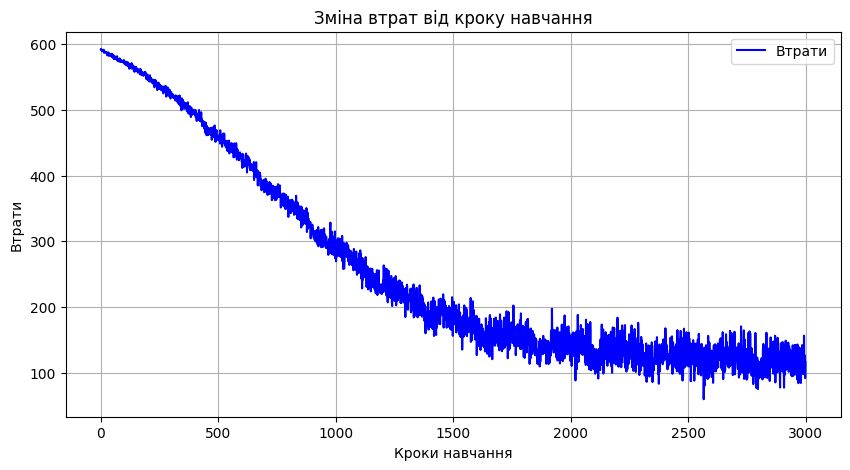

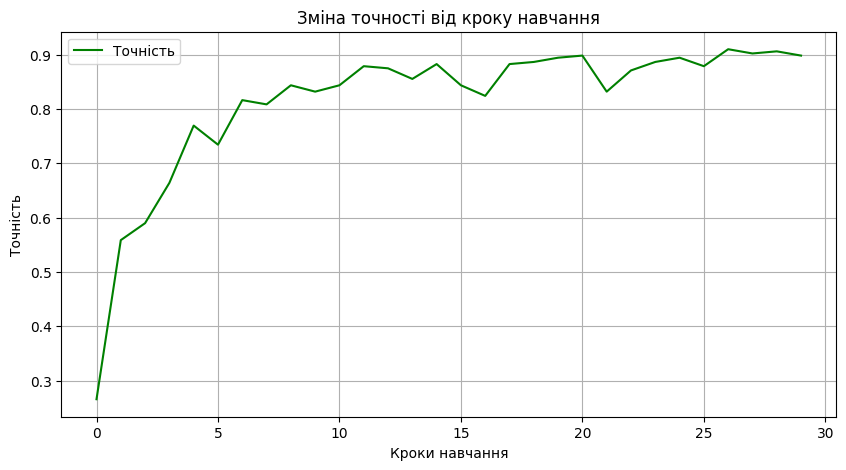

In [55]:
# Виведіть графіки залежності зміни точності і втрат від кроку
# Якщо все зроблено правильно, то точність повинна зростати, а втрати зменшуватись

import matplotlib.pyplot as plt

# Виведення графіка функції втрат
plt.figure(figsize=(10, 5))
plt.plot(loss_history, label='Втрати', color='blue')
plt.title('Зміна втрат від кроку навчання')
plt.xlabel('Кроки навчання')
plt.ylabel('Втрати')
plt.legend()
plt.grid(True)
plt.show()

# Виведення графіка точності
plt.figure(figsize=(10, 5))
plt.plot(accuracy_history, label='Точність', color='green')
plt.title('Зміна точності від кроку навчання')
plt.xlabel('Кроки навчання')
plt.ylabel('Точність')
plt.legend()
plt.grid(True)
plt.show()


In [64]:
# Тестування моделі на всьому тестовому наборі даних
predictions = neural_net(tf.convert_to_tensor(x_test, dtype=tf.float32))
y_pred = tf.argmax(predictions, axis=1).numpy()

# Обчислення точності
test_accuracy = accuracy_score(y_test, y_pred)
print(f"Точність на тестовому наборі даних: {test_accuracy * 100:.2f}%")

# Виведення додаткової інформації про продуктивність моделі
print(classification_report(y_test, y_pred))

Точність на тестовому наборі даних: 90.38%
              precision    recall  f1-score   support

           0       0.95      0.97      0.96       980
           1       0.97      0.96      0.97      1135
           2       0.90      0.90      0.90      1032
           3       0.88      0.88      0.88      1010
           4       0.87      0.94      0.90       982
           5       0.87      0.86      0.86       892
           6       0.92      0.91      0.91       958
           7       0.91      0.90      0.91      1028
           8       0.86      0.85      0.86       974
           9       0.88      0.85      0.87      1009

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.90     10000
weighted avg       0.90      0.90      0.90     10000



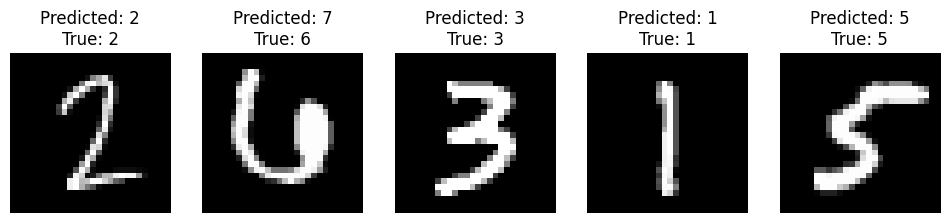

In [63]:
# Протестуйте навчену нейромережу на 10 зображеннях. З тестової вибірки візьміть 5
# випадкових зображень і передайте їх у нейронну мережу.
# Виведіть зображення та випишіть  поруч відповідь нейромережі.
# Зробіть висновок про те, чи помиляється твоя нейронна мережа, і якщо так, то як часто?


# Випадкові індекси для вибору зображень
random_indices = tf.random.uniform(shape=[5], minval=0, maxval=len(x_test), dtype=tf.int32)
images_to_test = tf.gather(x_test, random_indices)
labels_true = tf.gather(y_test, random_indices)

# Функція для виведення зображень і їх передбачень
def plot_images(images, labels_true, model, class_names):
    fig, axes = plt.subplots(1, len(images), figsize=(12, 3))
    for i, ax in enumerate(axes):
        # Показати зображення
        ax.imshow(np.reshape(images[i], (28, 28)), cmap='gray')
        ax.axis('off')
        # Отримати передбачення моделі
        image = tf.convert_to_tensor(images[i:i+1], dtype=tf.float32)
        prediction = model(image)
        predicted_label = np.argmax(prediction.numpy())
        # Показати передбачення і справжню мітку
        ax.set_title(f"Predicted: {class_names[predicted_label]}\nTrue: {class_names[labels_true[i]]}")

# Відображення зображень і їх передбачень
class_names = [str(i) for i in range(10)]  # Класи від 0 до 9
plot_images(images_to_test, labels_true, neural_net, class_names)
plt.show()

# Висновки
Точність моделі на тестовому наборі даних становить 90.38%.

Продуктивність по класах:

* Класи з найвищою точністю:
  * Клас 0: Точність 0.95
  * Клас 1: Точність 0.97


* Класи з найнижчою точністю:
  * Клас 8: Точність 0.86
  * Клас 5: Точність 0.87

Найнижчі значення f1-міри у класів 5 та 8. Це може свідчити про те, що ці класи складніше розпізнати, можливо через схожість з іншими класами або через варіативність рукописних цифр.


Отже, модель демонструє високу продуктивність на всіх класах, з точністю та повнотою, що перевищують 85% для всіх класів, загальна продуктивність з точністю понад 90%.

В цілому, модель достатньо точна для більшості практичних застосувань, хоча може потребувати подальшої оптимізації для класів з нижчою продуктивністю.